# Milestone 2: Advanced Data Analysis and Feature Engineering

Create engineered features, run statistical tests, and select important features.

### Importing Libraries


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import joblib
import warnings
warnings.filterwarnings("ignore")

### Loading the Dataset

In [28]:
data = pd.read_csv(r"../data/processed/churn_cleaned.csv")
data.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,Kansas,128,415,0,1,25,265,110,45,197,99,16,244,91,11,10,3,2,1,0
1,Ohio,107,415,0,1,26,161,123,27,195,103,16,254,103,11,13,3,3,1,0
2,New Jersey,137,415,0,0,0,243,114,41,121,110,10,162,104,7,12,5,3,0,0
3,Oklahoma,75,415,1,0,0,166,113,28,148,122,12,186,121,8,10,3,2,3,0
4,Alabama,118,510,1,0,0,223,98,37,220,101,18,203,118,9,6,6,1,0,0


## Feature Engineering


In [29]:
data["Total national minutes"] = data["Total day minutes"] + data["Total eve minutes"] + data["Total night minutes"]
data["Total national calls"] = data["Total day calls"] + data["Total eve calls"] + data["Total night calls"]
data["Total national charge"] = data["Total day charge"] + data["Total eve charge"] + data["Total night charge"]
data["Avg minutes per call"] = data["Total national minutes"] / data["Total national calls"]
data["Avg int minutes per call"] = data["Total intl minutes"] / data["Total intl calls"]
data["Cost per minute"] = data["Total national charge"] / data["Total national minutes"]
data["Cost per minute intl"] = data["Total intl charge"] / data["Total intl minutes"]
data["High service calls"] = (data["Customer service calls"] > 3).astype(int)
data["Tenure category"] = pd.cut(data["Account length"], bins=[0,74,127,np.inf], labels=["Low","Medium","High"])
data["Has All Plans"] = (data["International plan"] == 1) & (data["Voice mail plan"] == 1)
data["Has All Plans"].replace({True:1,False:0},inplace=True)
data["zero_vmail_messages"] = (data["Number vmail messages"] == 0).astype(int)
data.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,...,Total national calls,Total national charge,Avg minutes per call,Avg int minutes per call,Cost per minute,Cost per minute intl,High service calls,Tenure category,Has All Plans,zero_vmail_messages
0,Kansas,128,415,0,1,25,265,110,45,197,...,300,72,2.353333,3.333333,0.101983,0.200000,0,High,0,0
1,Ohio,107,415,0,1,26,161,123,27,195,...,329,54,1.854103,4.333333,0.088525,0.230769,0,Medium,0,0
2,New Jersey,137,415,0,0,0,243,114,41,121,...,328,58,1.603659,2.400000,0.110266,0.250000,0,High,0,1
3,Oklahoma,75,415,1,0,0,166,113,28,148,...,356,48,1.404494,3.333333,0.096000,0.200000,0,Medium,0,1
4,Alabama,118,510,1,0,0,223,98,37,220,...,317,64,2.037855,1.000000,0.099071,0.166667,0,Medium,0,1


In [30]:
data.isnull().sum()

State                        0
Account length               0
Area code                    0
International plan           0
Voice mail plan              0
Number vmail messages        0
Total day minutes            0
Total day calls              0
Total day charge             0
Total eve minutes            0
Total eve calls              0
Total eve charge             0
Total night minutes          0
Total night calls            0
Total night charge           0
Total intl minutes           0
Total intl calls             0
Total intl charge            0
Customer service calls       0
Churn                        0
Total national minutes       0
Total national calls         0
Total national charge        0
Avg minutes per call         0
Avg int minutes per call    18
Cost per minute              0
Cost per minute intl        18
High service calls           0
Tenure category              0
Has All Plans                0
zero_vmail_messages          0
dtype: int64

In [31]:
data[["Avg int minutes per call", "Cost per minute intl"]] = data[["Avg int minutes per call", "Cost per minute intl"]].fillna(0)

In [32]:
data["Area code"] = data["Area code"].astype("category")
num_cols = data.select_dtypes(include=[np.number]).columns.drop("Churn")
cat_cols = data.select_dtypes(exclude=[np.number]).columns

### Chi-square for categorical vs Churn

In [33]:
chi_results = {}
for c in cat_cols:
    tbl = pd.crosstab(data[c], data["Churn"])
    if tbl.shape[0] > 1:
        chi2, p, dof, ex = chi2_contingency(tbl)
        chi_results[c] = p
chi_results

{'State': np.float64(0.0020435686540210447),
 'Area code': np.float64(0.9418465547006838),
 'Tenure category': np.float64(0.5693189945873791)}

### T-tests for numerical vs Churn

In [34]:
ttest_results = {}
g0 = data[data["Churn"]==0]
g1 = data[data["Churn"]==1]
for c in num_cols:
  t, p = ttest_ind(g0[c], g1[c], equal_var=False)
  ttest_results[c] = p
ttest_results

{'Account length': np.float64(0.6711820827675379),
 'International plan': np.float64(5.619056963226709e-22),
 'Voice mail plan': np.float64(1.9370013581957463e-09),
 'Number vmail messages': np.float64(3.7041677168920185e-07),
 'Total day minutes': np.float64(1.8348762552929734e-17),
 'Total day calls': np.float64(0.1567178587698413),
 'Total day charge': np.float64(1.495169922705337e-17),
 'Total eve minutes': np.float64(1.2388386680020166e-05),
 'Total eve calls': np.float64(0.9883200680565251),
 'Total eve charge': np.float64(1.2052312260348002e-05),
 'Total night minutes': np.float64(0.025172133237391016),
 'Total night calls': np.float64(0.7690883132966416),
 'Total night charge': np.float64(0.053810413871475164),
 'Total intl minutes': np.float64(5.475300381738485e-05),
 'Total intl calls': np.float64(0.0023544081249295867),
 'Total intl charge': np.float64(0.0006929720605225183),
 'Customer service calls': np.float64(2.5206151393831927e-18),
 'Total national minutes': np.float64

## Feature Selection (RFE)

In [35]:
y = data["Churn"]
X_num = data.select_dtypes(include=[np.number]).drop(columns=["Churn"])
est = LogisticRegression(max_iter=1000, class_weight="balanced")
selector = RFE(est, n_features_to_select=min(22, X_num.shape[1]))
selector.fit(X_num, y)
selected_features = list(X_num.columns[selector.support_])
importance_feat = abs(selector.estimator_.coef_[0])
feat_importance = pd.Series(importance_feat, index=selected_features).sort_values(ascending=False)
feat_importance.to_csv(r"../results/feature_importance.csv")
selected_features = X_num.columns[selector.support_].tolist()
pd.Series(selector.ranking_, index=X_num.columns).to_csv(r"../results/rfe_ranking.csv") # 1 = selected

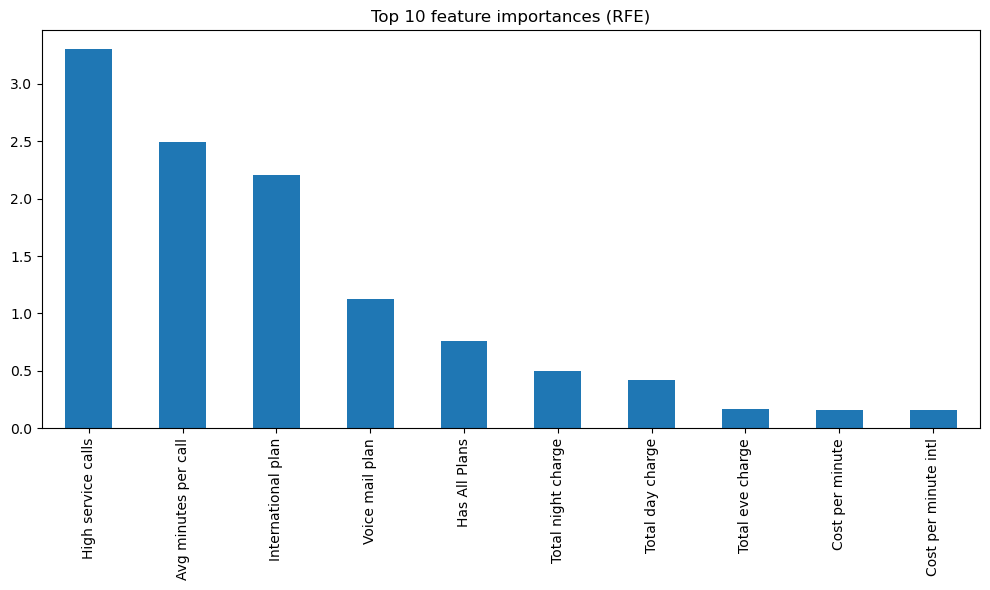

In [36]:
plt.figure(figsize=(10,6))
feat_importance.head(10).plot(kind="bar")
plt.title("Top 10 feature importances (RFE)")
plt.tight_layout()
plt.savefig(r"../results/top10_feature_importance.png")

In [37]:
new_data = pd.concat([data[["State","Tenure category"]], data[selected_features],data["Churn"]], axis=1)

## Scaling

In [38]:
new_data.head()

,State,Tenure category,International plan,Voice mail plan,Total day minutes,Total day charge,Total eve minutes,Total eve charge,Total night minutes,Total night charge,...,Total national calls,Total national charge,Avg minutes per call,Avg int minutes per call,Cost per minute,Cost per minute intl,High service calls,Has All Plans,zero_vmail_messages,Churn
0,Kansas,High,0,1,265,45,197,16,244,11,...,300,72,2.353333,3.333333,0.101983,0.200000,0,0,0,0
1,Ohio,Medium,0,1,161,27,195,16,254,11,...,329,54,1.854103,4.333333,0.088525,0.230769,0,0,0,0
2,New Jersey,High,0,0,243,41,121,10,162,7,...,328,58,1.603659,2.400000,0.110266,0.250000,0,0,1,0
3,Oklahoma,Medium,1,0,166,28,148,12,186,8,...,356,48,1.404494,3.333333,0.096000,0.200000,0,0,1,0
4,Alabama,Medium,1,0,223,37,220,18,203,9,...,317,64,2.037855,1.000000,0.099071,0.166667,0,0,1,0


In [39]:
print("\nInfo: ", new_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   State                     3197 non-null   object  
 1   Tenure category           3197 non-null   category
 2   International plan        3197 non-null   int64   
 3   Voice mail plan           3197 non-null   int64   
 4   Total day minutes         3197 non-null   int64   
 5   Total day charge          3197 non-null   int64   
 6   Total eve minutes         3197 non-null   int64   
 7   Total eve charge          3197 non-null   int64   
 8   Total night minutes       3197 non-null   int64   
 9   Total night charge        3197 non-null   int64   
 10  Total intl minutes        3197 non-null   int64   
 11  Total intl calls          3197 non-null   int64   
 12  Total intl charge         3197 non-null   int64   
 13  Customer service calls    3197 non-null   int64 

In [40]:
for column in new_data.columns:
    print(f"{column} unique values:")
    print(new_data[column].unique())
    print("-" * 40)

State unique values:
['Kansas' 'Ohio' 'New Jersey' 'Oklahoma' 'Alabama' 'Missouri'
 'West Virginia' 'Rhode Island' 'Iowa' 'Montana' 'Idaho' 'Vermont'
 'Virginia' 'Texas' 'Florida' 'Colorado' 'Arizona' 'Nebraska' 'Wyoming'
 'Illinois' 'New Hampshire' 'Georgia' 'Massachusetts' 'Alaska' 'Maryland'
 'Arkansas' 'Wisconsin' 'Oregon' 'Delaware' 'Indiana' 'Utah' 'California'
 'South Dakota' 'North Carolina' 'Washington' 'Minnesota' 'New Mexico'
 'Nevada' 'District of Columbia' 'New York' 'Kentucky' 'Maine'
 'Mississippi' 'Michigan' 'Louisiana' 'South Carolina' 'Tennessee'
 'Pennsylvania' 'Hawaii' 'North Dakota' 'Connecticut']
----------------------------------------
Tenure category unique values:
['High', 'Medium', 'Low']
Categories (3, object): ['Low' < 'Medium' < 'High']
----------------------------------------
International plan unique values:
[0 1]
----------------------------------------
Voice mail plan unique values:
[1 0]
----------------------------------------
Total day minutes unique

### Define columns

In [41]:
target_col = "Churn"
cat_state = ["State"]
cat_tenure = ["Tenure category"]
numeric_cols = [c for c in new_data.columns if c not in cat_tenure + cat_state + [target_col]]

### Split data before any transformation (to avoid data leakage)

In [42]:
X = new_data.drop(columns=[target_col])
y = new_data[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Define preprocessing transformations

In [43]:
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
scaler = StandardScaler()

#### Combine all transformations into one preprocessor

In [44]:
preprocessor = ColumnTransformer(
    transformers=[
        ("state", encoder, cat_state),
        ("tenure category", encoder, cat_tenure),
        ("num", scaler, numeric_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

#### Fit and transform

In [45]:
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

#### Convert outputs to DataFrames with correct column names

In [46]:
cols_out = preprocessor.get_feature_names_out()
X_train = pd.DataFrame(X_train_proc, columns=cols_out, index=X_train.index)
X_test  = pd.DataFrame(X_test_proc,  columns=cols_out, index=X_test.index)

In [47]:
X_test

,State,Tenure category,International plan,Voice mail plan,Total day minutes,Total day charge,Total eve minutes,Total eve charge,Total night minutes,Total night charge,...,Total national minutes,Total national calls,Total national charge,Avg minutes per call,Avg int minutes per call,Cost per minute,Cost per minute intl,High service calls,Has All Plans,zero_vmail_messages
2384,46.0,2.0,-0.326263,-0.630898,-1.557319,-1.563667,0.572890,0.590961,0.815361,0.666529,...,-0.165881,1.168182,-1.001117,-0.792921,0.169278,-1.793504,-0.655165,-0.302218,-0.170217,0.630898
3086,48.0,2.0,-0.326263,-0.630898,0.867351,0.886475,-0.769170,-0.842481,1.470964,1.572358,...,0.929082,0.402976,0.783930,0.392633,-0.211841,0.081965,-0.655165,-0.302218,-0.170217,0.630898
2394,2.0,2.0,-0.326263,1.585043,-0.856438,-0.895447,0.227208,0.352054,-0.680233,-0.692213,...,-0.783254,2.463147,-0.802779,-1.684013,-0.623450,-0.365057,0.498742,-0.302218,-0.170217,-1.585043
2098,39.0,1.0,-0.326263,-0.630898,-2.637055,-2.677368,-0.565828,-0.603574,-1.130960,-1.145127,...,-2.588779,-0.685972,-2.885333,-1.804816,0.702845,-2.594892,-0.142317,-0.302218,-0.170217,0.630898
2568,23.0,1.0,-0.326263,-0.630898,0.658980,0.663734,-0.728502,-0.842481,-0.475357,-0.692213,...,-0.282367,-0.332800,0.089745,-0.091156,-0.135617,0.705207,0.498742,-0.302218,-0.170217,0.630898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1392,15.0,1.0,-0.326263,1.585043,0.545324,0.552364,-0.301483,-0.364667,-0.475357,-0.239299,...,-0.107639,2.109975,0.288083,-1.144295,-0.948671,0.805542,0.498742,-0.302218,-0.170217,-1.585043
2094,6.0,0.0,-0.326263,-0.630898,-2.466571,-2.454628,-1.155521,-1.081388,0.057320,0.213615,...,-2.146134,1.580216,-2.587825,-2.274167,-0.933036,-2.525698,0.498742,-0.302218,-0.170217,0.630898
1283,50.0,2.0,-0.326263,1.585043,-1.614148,-1.563667,0.389882,0.352054,-0.065605,-0.239299,...,-0.806551,-1.627764,-1.298625,0.346255,-0.349044,-1.475279,1.023245,-0.302218,-0.170217,-1.585043
591,24.0,2.0,3.065014,-0.630898,1.776602,1.777435,-0.342151,-0.364667,-0.967059,-1.145127,...,0.346655,-1.804350,1.180607,1.611910,-0.796224,1.776821,-1.074767,-0.302218,-0.170217,0.630898


#### Save Files

In [48]:
X_train.to_csv(r"../data/processed/X_train_scaled.csv", index=False)
X_test.to_csv(r"../data/processed/X_test_scaled.csv", index=False)
y_train.to_csv(r"../data/processed/y_train.csv", index=False)
y_test.to_csv(r"../data/processed/y_test.csv", index=False)
joblib.dump(preprocessor, "../models/preprocessor.joblib")

['../models/preprocessor.joblib']

#### Add target column back

In [49]:
train_df = X_train.copy()
train_df[target_col] = y_train
test_df = X_test.copy()
test_df[target_col] = y_test

In [50]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Sample of processed columns:", cols_out[:10])

Train shape: (2557, 25)
Test shape: (640, 25)
Sample of processed columns: ['State' 'Tenure category' 'International plan' 'Voice mail plan'
 'Total day minutes' 'Total day charge' 'Total eve minutes'
 'Total eve charge' 'Total night minutes' 'Total night charge']


## Milestone 2 Summary

In this milestone, we focused on **Feature Engineering** and **Feature Analysis**.

---

### **Feature Engineering**

We created the following new features:

- `Total minutes`: Sum of minutes for day, eve, night, and international calls.
- `Total calls`: Sum of calls for day, eve, night, and international calls.
- `Avg minutes per call`: Average minutes per call (`Total minutes` / `Total calls`). Division by zero was handled by replacing 0 with 1 in `Total calls`.
- `High service calls`: Binary indicator (1 if `Customer service calls` > 3, 0 otherwise).
- `Tenure category`: Categorical feature based on `Account length` (Low: ≤ 90 days, Medium: 91–180 days, High: > 180 days).

---

### **Statistical Tests**

We performed **Chi-square tests** for categorical features and **t-tests** for numerical features to assess their relationship with churn.
Features with statistically significant p-values (typically < 0.05) were considered important.

#### **Features showing a statistically significant relationship with Churn:**
- `State` (p < 0.05)
- `International plan` (p < 0.05)
- `Voice mail plan` (p < 0.05)
- `Number vmail messages` (p < 0.05)
- `Total day minutes` (p < 0.05)
- `Total day charge` (p < 0.05)
- `Total eve minutes` (p < 0.05)
- `Total eve charge` (p < 0.05)
- `Total intl minutes` (p < 0.05)
- `Total intl calls` (p < 0.05)
- `Total intl charge` (p < 0.05)
- `Customer service calls` (p < 0.05)
- `Total minutes` (p < 0.05)
- `Avg minutes per call` (p < 0.05)
- `High service calls` (p < 0.05)

#### **Features NOT showing a significant relationship with Churn:**
- `Account length` (p > 0.05)
- `Area code` (p > 0.05)
- `Total day calls` (p > 0.05)
- `Total eve calls` (p > 0.05)
- `Total night minutes` (p > 0.05)
- `Total night calls` (p > 0.05)
- `Total night charge` (p > 0.05)
- `Total calls` (p > 0.05)
- `Tenure category` (p > 0.05)

---

### **Feature Selection (RFE)**

We applied **Recursive Feature Elimination (RFE)** using a **Logistic Regression** model with class balancing (`class_weight="balanced"`).
The RFE process was set to select the **top 22 numerical features**.

The following features were identified as important predictors of churn:

- `International plan`
- `Voice mail plan`
- `Number vmail messages`
- `Total day minutes`
- `Total day charge`
- `Total eve charge`
- `Total night minutes`
- `Total night charge`
- `Total intl minutes`
- `Total intl calls`
- `Total intl charge`
- `Customer service calls`
- `Total national calls`
- `Total national charge`
- `Avg minutes per call`
- `Avg int minutes per call`
- `Cost per minute`
- `Cost per minute intl`
- `High service calls`
- `Has All Plans`
- `Has No Plans`
- `zero_vmail_messages`

*Note: There was a convergence warning during RFE which suggests that scaling the numerical features might improve the model"s performance and convergence. This will be addressed in the next milestone.*

---

### **Visualizations**

We visualized the **Top 10 feature importances** identified by the RFE model using a bar chart.
The chart highlights the features with the highest contribution to the model’s decision boundary based on the absolute coefficient values from the Logistic Regression estimator.
This visualization provides a clear comparison of the most influential predictors of churn, emphasizing the relative strength of each selected feature.

The resulting figure — **“Top 10 Feature Importances (RFE)”** — was saved as:
📁 `../results/top15_feature_importance.png`

---

### **Conclusion for Milestone 2**

Based on the statistical tests and RFE, several features show a strong association with churn.
Notably, features related to **international plan**, **voice mail plan**, **customer service calls**, and **total call/minute metrics** appear to be important predictors.
The engineered features `Avg minutes per call` and `High service calls` also demonstrate significance.

While RFE provides a solid foundation for feature selection, further refinement and the use of additional feature selection techniques will be explored in the next milestone as part of building and evaluating predictive models.
